In [1]:
from matplotlib import pyplot as plt
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import rnn
from mxnet.gluon import nn
npx.set_np()

#  10. Attention Mechanisms
As a bit of a historical digression, attention research is an enormous field with a long history in cognitive neuroscience. Focalization, concentration of consciousness are of the essence of attention, which enable the human to prioritize the perception in order to deal effectively with others. As a result, we do not process all the information that is available in the sensory input. At any time, we are aware of only a small fraction of the information in the environment. In cognitive neuroscience, there are several types of attention such as selective attention, covert attention, and spatial attention. The theory ignites the spark in recent deep learning is the `feature integration theory` of the selective attention, which was developed by Anne Treisman and Garry Gelade through the paper (`Treisman & Gelade, 1980`) in 1980. This paper declares that when perceiving a stimulus, features are registered early, automatically, and in parallel, while objects are identified separately and at a later stage in processing. The theory has been one of the most influential psychological models of human visual attention.

However, we will not indulge in too much theory of attention in neuroscience, but rather focus on applying the attention idea in deep learning, where attention can be seen as a generalized pooling method with bias alignment over inputs. In this chapter, we will provide you with some intuition about how to transform the attention idea to the concrete mathematics models, and make them work.

## 10.1 Attention Mechanisms
In `Section 9.7`, we encode the source sequence input information in the recurrent unit state and then pass it to the `decoder` to generate the target sequence. A token in the target sequence may closely relate to one or more tokens in the source sequence, instead of the whole source sequence. For example, when translating "Hello world." to "Bonjour le monde.", "Bonjour" maps to "Hello" and "monde" maps to "world". In the `seq2seq` model, the `decoder` may implicitly select the corresponding information from the state passed by the `encoder`. The attention mechanism, however, makes this selection explicit.

`Attention` is a generalized pooling method with bias alignment over inputs. The core component in the attention mechanism is the `attention layer`, or called `attention` for simplicity. An input of the `attention layer` is called a `query`. For a `query`, `attention` returns an output based on the memory---a set of key-value pairs encoded in the `attention layer`. 

To be more specific, assume that the memory contains $n$ key-value pairs, $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_n, \mathbf{v}_n)$, with $\mathbf{k}_i \in \mathbb R^{d_k}$, $\mathbf{v}_i \in \mathbb R^{d_v}$. Given a query $\mathbf{q} \in \mathbb R^{d_q}$, the attention layer returns an output $\mathbf{o} \in \mathbb R^{d_v}$ with the same shape as the value.

<img src="images/10_01.png" style="width:600px;"/>

The full process of attention mechanism is expressed in `Fig. 10.1.2`. To compute the output of attention, we first use a score function $\alpha$ that measures the similarity between the query and the key. So for each key $\mathbf{k}_1, \ldots, \mathbf{k}_n$, we compute the scores $a_1, \ldots, a_n$ by

$$a_i = \alpha(\mathbf q, \mathbf k_i).$$

Next we use softmax to obtain the attention weights, i.e.,

$$\mathbf{b} = \mathrm{softmax}(\mathbf{a})\quad \text{, where }\quad {b}_i = \frac{\exp(a_i)}{\displaystyle\sum_j \exp(a_j)}, \mathbf{b} = [b_1, \ldots, b_n]^T .$$

Finally, the output is a weighted sum of the values:

$$\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.$$

<img src="images/10_02.png" style="width:400px;"/>

Different choices of the score function lead to different `attention layers`. Below, we introduce two commonly used `attention layers`. Before diving into the implementation, we first express two operators to get you up and running: a masked version of the softmax operator `masked_softmax` and a specialized dot operator `batch_dot`.

The masked softmax takes a 3-dimensional input and enables us to filter out some elements by specifying a valid length for the last dimension. (Refer to `Section 9.5` for the definition of a valid length.) As a result, any value outside the valid length will be masked as $0$. Let us implement the `masked_softmax` function.

In [2]:
def masked_softmax(X, valid_len):
    """Perform softmax by filtering out some elements."""
    # X: 3-D tensor, valid_len: 1-D or 2-D tensor
    if valid_len is None:
        return npx.softmax(X)
    else:
        shape = X.shape
        if valid_len.ndim == 1:
            valid_len = valid_len.repeat(shape[1], axis=0)
        else:
            valid_len = valid_len.reshape(-1)
        # Fill masked elements with a large negative, whose exp is 0
        X = npx.sequence_mask(X.reshape(-1, shape[-1]), valid_len, True, axis=1, value=-1e6)
        return npx.softmax(X).reshape(shape)

To illustrate how this function works, we construct two $2 \times 4$ matrices as the input. In addition, we specify that the valid length equals to 2 for the first example, and 3 for the second example. Then, as we can see from the following outputs, the values outside valid lengths are masked as zero.

In [3]:
masked_softmax(np.random.uniform(size=(2, 2, 4)), np.array([2, 3]))

array([[[0.488994  , 0.511006  , 0.        , 0.        ],
        [0.43654838, 0.56345165, 0.        , 0.        ]],

       [[0.28817102, 0.3519408 , 0.3598882 , 0.        ],
        [0.29034293, 0.25239873, 0.45725834, 0.        ]]])

Moreover, the second operator `batch_dot` takes two inputs $X$ and $Y$ with shapes $(b, n, m)$ and $(b, m, k)$, respectively, and returns an output with shape $(b, n, k)$. To be specific, it computes $b$ dot products for $i= {1,\ldots, b}$, i.e., 

$$Z[i,:,:] = X[i,:,:] Y[i,:,:].$$

In [4]:
m1 = np.ones((2, 1, 3))
m2 = np.ones((2, 3, 2))
m1, m2, npx.batch_dot(m1, m2)

(array([[[1., 1., 1.]],
 
        [[1., 1., 1.]]]),
 array([[[1., 1.],
         [1., 1.],
         [1., 1.]],
 
        [[1., 1.],
         [1., 1.],
         [1., 1.]]]),
 array([[[3., 3.]],
 
        [[3., 3.]]]))

### 10.1.1 Dot Product Attention
Equipped with the above two operators: `masked_softmax` and `batch_dot`, let us dive into the details of two widely used attention layers. The first one is the `dot product attention`: it assumes that the query has the same dimension as the keys, namely $\mathbf q, \mathbf k_i \in\mathbb R^d$ for all $i$. The dot product attention computes the scores by a dot product between the query and a key, which is then divided by $\sqrt{d}$ to minimize the unrelated influence of the dimension $d$ on the scores. In other words,

$$\alpha(\mathbf q, \mathbf k) = \frac{\langle \mathbf q, \mathbf k \rangle}{\sqrt{d}}.$$

Beyond the single-dimensional queries and keys, we can always generalize them to multi-dimensional queries and keys. Assume that $\mathbf Q\in\mathbb R^{m\times d}$ contains $m$ queries and $\mathbf K\in\mathbb R^{n\times d}$ has all the $n$ keys. We can compute all $mn$ scores by

$$\alpha(\mathbf Q, \mathbf K) = \frac{\mathbf Q \mathbf K^\top}{\sqrt{d}} \qquad (10.1.6)$$ 

With (`10.1.6`), we can implement the dot product attention layer `DotProductAttention` that supports a batch of queries and key-value pairs. In addition, for regularization we also use a `dropout` layer.

In [5]:
class DotProductAttention(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `query`: (`batch_size`, #queries, `d`)
    # `key`: (`batch_size`, #kv_pairs, `d`)
    # `value`: (`batch_size`, #kv_pairs, `dim_v`)
    # `valid_len`: either (`batch_size`, ) or (`batch_size`, xx)
    def forward(self, query, key, value, valid_len=None):
        d = query.shape[-1]
        # Set transpose_b=True to swap the last two dimensions of key
        scores = npx.batch_dot(query, key, transpose_b=True) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return npx.batch_dot(attention_weights, value)

Let us test the class `DotProductAttention` in a toy example. First, create two batches, where each batch has one query and 10 key-value pairs. Via the `valid_len` argument, we specify that we will check the first $2$ key-value pairs for the first batch and $6$ for the second one. Therefore, even though both batches have the same query and key-value pairs, we obtain different outputs.

In [6]:
atten = DotProductAttention(dropout=0.5)
atten.initialize()
keys = np.ones((2, 10, 2))
values = np.arange(40).reshape(1, 10, 4).repeat(2, axis=0)
atten(np.ones((2, 1, 2)), keys, values, np.array([2, 6]))

array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]])

As we can see above, dot product attention simply multiplies the query and key together, and hopes to derive their similarities from there. Whereas, the query and key may not be of the same dimension. To address such an issue, we may resort to the multilayer perceptron attention.

### 10.1.2 Multilayer Perceptron Attention
In multilayer perceptron attention, we project both query and keys into $\mathbb R^{h}$ by learnable weights parameters. Assume that the learnable weights are $\mathbf W_k\in\mathbb R^{h\times d_k}$, $\mathbf W_q\in\mathbb R^{h\times d_q}$, and $\mathbf v\in\mathbb R^{h}$. Then the score function is defined by

$$\alpha(\mathbf k, \mathbf q) = \mathbf v^\top \text{tanh}(\mathbf W_k \mathbf k + \mathbf W_q\mathbf q).$$

Intuitively, you can imagine $\mathbf W_k \mathbf k + \mathbf W_q\mathbf q$ as concatenating the key and value in the feature dimension and feeding them to a single hidden layer perceptron with hidden layer size $h$ and output layer size $1$. In this hidden layer, the activation function is $\tanh$ and no bias is applied. Now let us implement the multilayer perceptron attention.

In [7]:
class MLPAttention(nn.Block):
    def __init__(self, units, dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        # Use flatten=False to keep query's and key's 3-D shapes
        self.W_k = nn.Dense(units, use_bias=False, flatten=False)
        self.W_q = nn.Dense(units, use_bias=False, flatten=False)
        self.v = nn.Dense(1, use_bias=False, flatten=False)
        self.dropout = nn.Dropout(dropout)


    def forward(self, query, key, value, valid_len):
        query, key = self.W_q(query), self.W_k(key)
        # Expand query to (`batch_size`, #queries, 1, units), and key to
        # (`batch_size`, 1, #kv_pairs, units). Then plus them with broadcast
        features = np.expand_dims(query, axis=2) + np.expand_dims(key, axis=1)
        features = np.tanh(features)
        scores = np.squeeze(self.v(features), axis=-1)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return npx.batch_dot(attention_weights, value)

To test the above `MLPAttention` class, we use the same inputs as in the previous toy example. As we can see below, despite `MLPAttention` containing an additional `MLP` model, we obtain the same outputs as for `DotProductAttention`.

In [8]:
atten = MLPAttention(units=8, dropout=0.1)
atten.initialize()
atten(np.ones((2, 1, 2)), keys, values, np.array([2, 6]))

array([[[ 2.      ,  3.      ,  4.      ,  5.      ]],

       [[10.      , 11.      , 12.000001, 13.      ]]])

##### Summary
+ An attention layer explicitly selects related information.
+ An attention layer's memory consists of key-value pairs, so its output is close to the values whose keys are similar to the queries.
+ Two commonly used attention models are dot product attention and multilayer perceptron attention.

##### Exercises
1. What are the advantages and disadvantages for dot product attention and multilayer perceptron attention, respectively?


## 10.2 seq2seq with Attention Mechanisms
In this section, we add the attention mechanism to the `sequence to sequence` (`seq2seq`) model as introduced in `Section 9.7` to explicitly aggregate states with weights. `Fig. 10.2.1` shows the model architecture for encoding and decoding at the timestep $t$. Here, the memory of the `attention layer` consists of all the information that the `encoder` has seen---the `encoder` output at each timestep. During the decoding, the `decoder` output from the previous timestep $t-1$ is used as the `query`. The output of the attention model is viewed as the context information, and such context is concatenated with the `decoder` input $D_t$. Finally, we feed the concatenation into the `decoder`.

<img src="images/10_03.png" style="width:600px;"/>

To illustrate the overall architecture of `seq2seq` with attention model, the layer structure of its `encoder` and `decoder` is shown in `Fig. 10.2.2`.

<img src="images/10_04.png" style="width:600px;"/>

### 10.2.1 Decoder
Since the `encoder` of `seq2seq` with attention mechanisms is the same as `Seq2SeqEncoder` in `Section 9.7`, we will just focus on the `decoder`. We add an MLP attention layer (`MLPAttention`) which has the same hidden size as the `LSTM` layer in the decoder. Then we initialize the state of the `decoder` by passing three items from the `encoder`:
+ the `encoder` outputs of all timesteps: they are used as the attention layer's memory with identical keys and values
+ the hidden state of the `encoder`'s final timestep: it is used as the initial `decoder`'s hidden state
+ the `encoder` valid length: so the attention layer will not consider the padding tokens within the `encoder` outputs

At each timestep of the decoding, we use the output of the `decoder`'s last RNN layer as the `query` for the `attention layer`. The attention model's output is then concatenated with the input embedding vector to feed into the RNN layer. Although the RNN layer hidden state also contains history information from `decoder`, the attention output explicitly selects the `encoder` outputs based on `enc_valid_len`, so that the attention output suspends other irrelevant information.

Let us implement the `Seq2SeqAttentionDecoder`, and see how it differs from the `decoder` in `seq2seq` from `Section 9.7.2`.

In [9]:
class Seq2SeqAttentionDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention_cell = d2l.MLPAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = rnn.LSTM(num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, enc_valid_len, *args):
        outputs, hidden_state = enc_outputs
        # Transpose `outputs` to (`batch_size`, `seq_len`, `num_hiddens`)
        return (outputs.swapaxes(0, 1), hidden_state, enc_valid_len)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_len = state
        X = self.embedding(X).swapaxes(0, 1)
        outputs = []
        for x in X:
            # `query` shape: (`batch_size`, 1, `num_hiddens`)
            query = np.expand_dims(hidden_state[0][-1], axis=1)
            # `context` has same shape as `query`
            context = self.attention_cell(query, enc_outputs, enc_outputs, enc_valid_len)
            # Concatenate on the feature dimension
            x = np.concatenate((context, np.expand_dims(x, axis=1)), axis=-1)
            # Reshape `x` to (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.swapaxes(0, 1), hidden_state)
            outputs.append(out)
        outputs = self.dense(np.concatenate(outputs, axis=0))
        return outputs.swapaxes(0, 1), [enc_outputs, hidden_state, enc_valid_len]

Now we can test the `seq2seq` with attention model. To be consistent with the model without attention in `Section 9.7`, we use the same hyper-parameters for `vocab_size`, `embed_size`, `num_hiddens`, and `num_layers`. As a result, we get the same `decoder` output shape, but the state structure is changed.

In [10]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.initialize()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.initialize()
X = np.zeros((4, 7))
state = decoder.init_state(encoder(X), None)
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

((4, 7, 10), 3, (4, 7, 16), 2, (2, 4, 16))

### 10.2.2 Training
Similar to `Section 9.7.4`, we try a toy model by applying the same training hyperparameters and the same training loss. As we can see from the result, since the sequences in the training dataset are relatively short, the additional attention layer does not lead to a significant improvement. Due to the computational overhead of both the `encoder`'s and the `decoder`'s attention layers, this model is much slower than the `seq2seq` model without attention.

loss 0.037, 4801 tokens/sec on gpu(0) 


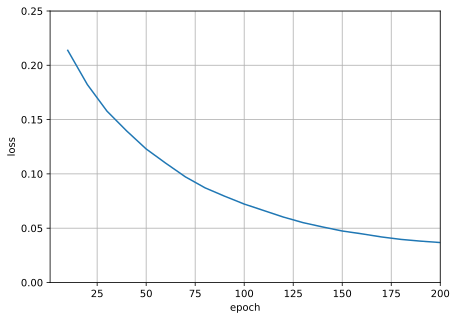

In [11]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, ctx = 0.005, 200, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, ctx)

Last, we predict several sample examples.

In [12]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

Go . => va !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => je vais bien .


##### Summary
+ The `seq2seq` model with attention adds an additional `attention layer` to the model without attention.
+ The `decoder` of the `seq2seq` with attention model passes three items from the `encoder`: 
    + the `encoder` outputs of all timesteps
    + the hidden state of the `encoder`'s final timestep
    + the `encoder` valid length
   
##### Exercises
1. Compare `Seq2SeqAttentionDecoder` and `Seq2seqDecoder` by using the same parameters and checking their losses.
2. Can you think of any use cases where `Seq2SeqAttentionDecoder` will outperform `Seq2seqDecoder`?


## 10.3 Transformer
In previous chapters, we have covered major neural network architectures such as `convolution neural networks` (CNNs) and `recurrent neural networks` (RNNs). Let us recap their pros and cons:
+ **CNN** are easy to parallelize at a layer but cannot capture the variable-length sequential dependency very well
+ **RNN** are able to capture the long-range, variable-length sequential information, but suffer from inability to parallelize within a sequence

To combine the advantages from both CNNs and RNNs, (`Vaswani et al., 2017`) designed a novel architecture using the attention mechanism. This architecture, which is called as `Transformer`, achieves parallelization by capturing recurrence sequence with attention and at the same time encodes each item's position in the sequence. As a result, `Transformer` leads to a compatible model with significantly shorter training time.

Similar to the `seq2seq` model in `Section 9.7`, `Transformer` is also based on the `encoder-decoder` architecture. However, `Transformer` differs to the former by replacing the recurrent layers in `seq2seq` with `multi-head attention layers`, incorporating the position-wise information through position encoding, and applying layer normalization. We compare `Transformer` and `seq2seq` side-by-side in `Fig. 10.3.1`.

Overall, these two models are similar to each other: the source sequence embeddings are fed into $n$ repeated blocks. The outputs of the last block are then used as attention memory for the `decoder`. The target sequence embeddings are similarly fed into $n$ repeated blocks in the `decoder`, and the final outputs are obtained by applying a dense layer with vocabulary size to the last block's outputs.

<img src="images/10_05.png" style="width:600px;"/>

On the flip side, `Transformer` differs from the `seq2seq` with attention model in the following:
+ **Transformer block**: a recurrent layer in `seq2seq` is replaced by a `Transformer block`. This block contains a multi-head attention layer and a position-wise feed-forward network with two layers for the `encoder`. For the `decoder`, another multi-head attention layer is used to take the `encoder` state
+ **Add and norm**: the inputs and outputs of both the multi-head attention layer or the position-wise feed-forward network, are processed by two `add and norm` layer that contains a residual structure and a layer normalization layer
+ **Position encoding**: since the self-attention layer does not distinguish the item order in a sequence, a positional encoding layer is used to add sequential information into each sequence item

In the rest of this section, we will equip you with each new component introduced by `Transformer`, and get you up and running to construct a machine translation model.

### 10.3.1 Multi-Head Attention
Before the discussion of the multi-head attention layer, let us quick express the `self-attention architecture`. The self-attention model is a normal attention model, with its query, its key, and its value being copied exactly the same from each item of the sequential inputs. As we illustrate in `Fig. 10.3.2`, self-attention outputs a same-length sequential output for each input item. Compared with a recurrent layer, output items of a self-attention layer can be computed in parallel and, therefore, it is easy to obtain a highly-efficient implementation.

<img src="images/10_06.png" style="width:350px;"/>

The `multi-head attention layer` consists of $h$ parallel self-attention layers, each one is called a `head`. For each head, before feeding into the attention layer, we project the queries, keys, and values with three dense layers with hidden sizes $p_q$, $p_k$, and $p_v$, respectively. The outputs of these $h$ attention heads are concatenated and then processed by a final dense layer.

<img src="images/10_07.png" style="width:450px;"/>

Assume that the dimension for a query, a key, and a value are $d_q$, $d_k$, and $d_v$, respectively. Then, for each head $i=1,\ldots, h$, we can train learnable parameters $\mathbf W_q^{(i)}\in\mathbb R^{p_q\times d_q}$, $\mathbf W_k^{(i)}\in\mathbb R^{p_k\times d_k}$, and $\mathbf W_v^{(i)}\in\mathbb R^{p_v\times d_v}$. Therefore, the output for each head is

$$\mathbf o^{(i)} = \textrm{attention}(\mathbf W_q^{(i)}\mathbf q, \mathbf W_k^{(i)}\mathbf k,\mathbf W_v^{(i)}\mathbf v),$$

where $\textrm{attention}$ can be any attention layer, such as the `DotProductAttention` and `MLPAttention` as we introduced in `Section 10.1`.

After that, the output with length $p_v$ from each of the $h$ attention heads are concatenated to be an output of length $h p_v$, which is then passed the final dense layer with $d_o$ hidden units. The weights of this dense layer can be denoted by $\mathbf W_o\in\mathbb R^{d_o\times h p_v}$. As a result, the multi-head attention output will be

$$\mathbf o = \mathbf W_o \begin{bmatrix}\mathbf o^{(1)} \\ \vdots \\ \mathbf o^{(h)}\end{bmatrix}.$$

Now we can implement the multi-head attention. Assume that the multi-head attention contain the number heads num_heads $=h$, the hidden size num_hiddens $=p_q=p_k=p_v$ are the same for the query, key, and value dense layers. In addition, since the multi-head attention keeps the same dimensionality between its input and its output, we have the output feature size $d_o =$ num_hiddens as well.

In [13]:
class MultiHeadAttention(nn.Block):
    def __init__(self, num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
        self.W_k = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
        self.W_v = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
        self.W_o = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)

    def forward(self, query, key, value, valid_len):
        # For self-attention, `query`, `key`, and `value` shape:
        # (`batch_size`, `seq_len`, `dim`), where `seq_len` is the length of
        # input sequence. `valid_len` shape is either (`batch_size`, ) or
        # (`batch_size`, `seq_len`).
        # Project and transpose `query`, `key`, and `value` from
        # (`batch_size`, `seq_len`, `num_hiddens`) to
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        query = transpose_qkv(self.W_q(query), self.num_heads)
        key = transpose_qkv(self.W_k(key), self.num_heads)
        value = transpose_qkv(self.W_v(value), self.num_heads)

        if valid_len is not None:
            # Copy `valid_len` by `num_heads` times
            if valid_len.ndim == 1:
                valid_len = np.tile(valid_len, self.num_heads)
            else:
                valid_len = np.tile(valid_len, (self.num_heads, 1))

        # For self-attention, `output` shape:
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        output = self.attention(query, key, value, valid_len)
        # `output_concat` shape: (`batch_size`, `seq_len`, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

Here are the definitions of the transpose functions `transpose_qkv` and `transpose_output`, which are the inverse of each other.

In [14]:
def transpose_qkv(X, num_heads):
    # Input `X` shape: (`batch_size`, `seq_len`, `num_hiddens`).
    # Output `X` shape:
    # (`batch_size`, `seq_len`, `num_heads`, `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # `X` shape:
    # (`batch_size`, `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    X = X.transpose(0, 2, 1, 3)
    # `output` shape:
    # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    return output

def transpose_output(X, num_heads):
    # A reversed version of `transpose_qkv`
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.transpose(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

Let us test the `MultiHeadAttention` model in the a toy example. Create a multi-head attention with the hidden size $d_o = 100$, the output will share the same batch size and sequence length as the input, but the last dimension will be equal to the num_hiddens $= 100$.

In [15]:
cell = MultiHeadAttention(90, 9, 0.5)
cell.initialize()
X = np.ones((2, 4, 5))
valid_len = np.array([2, 3])
cell(X, X, X, valid_len).shape

(2, 4, 90)

### 10.3.2 Position-wise Feed-Forward Networks
Another key component in the `Transformer` block is called `position-wise feed-forward network` (`FFN`). It accepts a $3$-dimensional input with shape `(batch size, sequence length, feature size)`. The `position-wise FFN` consists of two dense layers that applies to the last dimension. Since the same two dense layers are used for each position item in the sequence, we referred to it as `position-wise`. Indeed, it is equivalent to applying two $1 \times 1$ convolution layers.

Below, the `PositionWiseFFN` shows how to implement a `position-wise FFN` with two dense layers of hidden size `ffn_num_hiddens` and `pw_num_outputs`, respectively.

In [16]:
class PositionWiseFFN(nn.Block):
    def __init__(self, ffn_num_hiddens, pw_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Dense(ffn_num_hiddens, flatten=False, activation='relu')
        self.dense2 = nn.Dense(pw_num_outputs, flatten=False)

    def forward(self, X):
        return self.dense2(self.dense1(X))

Similar to the `multi-head attention`, the `position-wise feed-forward network` will only change the last dimension size of the input---the feature dimension. In addition, if two items in the input sequence are identical, the according outputs will be identical as well.

In [17]:
ffn = PositionWiseFFN(4, 8)
ffn.initialize()
ffn(np.ones((2, 3, 4)))[0]

array([[ 0.00477083,  0.00153209,  0.00054869,  0.00365449, -0.00151314,
        -0.00552379, -0.00764116,  0.00688283],
       [ 0.00477083,  0.00153209,  0.00054869,  0.00365449, -0.00151314,
        -0.00552379, -0.00764116,  0.00688283],
       [ 0.00477083,  0.00153209,  0.00054869,  0.00365449, -0.00151314,
        -0.00552379, -0.00764116,  0.00688283]])

### 10.3.3 Add and Norm
Besides the above two components in the `Transformer` block, the "add and norm" within the block also plays a key role to connect the inputs and outputs of other layers smoothly. To explain, we add a layer that contains a residual structure and a `layer normalization` after both the `multi-head attention layer` and the `position-wise FFN` network. `Layer normalization` is similar to `batch normalization` in `Section 7.5`. One difference is that the mean and variances for the `layer normalization` are calculated along the last dimension, e.g `X.mean(axis=-1)` instead of the first batch dimension, e.g., `X.mean(axis=0)`. `Layer normalization` prevents the range of values in the layers from changing too much, which allows faster training and better generalization ability.

`MXNet` has both `LayerNorm` and `BatchNorm` implemented within the `nn` block. Let us call both of them and see the difference in the example below.

In [18]:
layer = nn.LayerNorm()
layer.initialize()
batch = nn.BatchNorm()
batch.initialize()
X = np.array([[1, 2], [2, 3]])
# Compute mean and variance from `X` in the training mode
with autograd.record():
    print('layer norm:', layer(X), '\nbatch norm:', batch(X))

layer norm: [[-0.99998  0.99998]
 [-0.99998  0.99998]] 
batch norm: [[-0.99998 -0.99998]
 [ 0.99998  0.99998]]


Now let us implement the connection block `AddNorm` together. `AddNorm` accepts two inputs $X$ and $Y$. We can deem $X$ as the original input in the residual network, and $Y$ as the outputs from either the `multi-head attention layer` or the `position-wise FFN` network. In addition, we apply dropout on $Y$ for regularization.

In [19]:
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm()

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

Due to the residual connection, $X$ and $Y$ should have the same shape.

In [20]:
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(np.ones((2, 3, 4)), np.ones((2, 3, 4))).shape

(2, 3, 4)

### 10.3.4 Positional Encoding
Unlike the recurrent layer, both the `multi-head attention layer` and the `position-wise feed-forward network` compute the output of each item in the sequence independently. This feature enables us to parallelize the computation, but it fails to model the sequential information for a given sequence. To better capture the sequential information, the `Transformer` model uses the positional encoding to maintain the positional information of the input sequence.

To explain, assume that $X\in\mathbb R^{l\times d}$ is the embedding of an example, where $l$ is the sequence length and $d$ is the embedding size. This positional encoding layer encodes X's position $P\in\mathbb R^{l\times d}$ and outputs $P+X$.

The position $P$ is a 2-D matrix, where $i$ refers to the order in the sentence, and $j$ refers to the position along the embedding vector dimension. In this way, each value in the origin sequence is then maintained using the equations below:

$$P_{i, 2j} = \sin(i/10000^{2j/d}),$$

$$\quad P_{i, 2j+1} = \cos(i/10000^{2j/d}),$$

for $i=0,\ldots, l-1$ and $j=0,\ldots,\lfloor(d-1)/2\rfloor$.

`Fig. 10.3.4` illustrates the positional encoding.

<img src="images/10_08.png" style="width:450px;"/>

In [21]:
class PositionalEncoding(nn.Block):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = np.zeros((1, max_len, num_hiddens))
        X = np.arange(0, max_len).reshape(-1, 1)/np.power(10000, np.arange(0, num_hiddens, 2)/num_hiddens)
        self.P[:, :, 0::2] = np.sin(X)
        self.P[:, :, 1::2] = np.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].as_in_ctx(X.ctx)
        return self.dropout(X)

Now we test the `PositionalEncoding` class with a toy model for 4 dimensions. As we can see, the $4^{\mathrm{th}}$ dimension has the same frequency as the $5^{\mathrm{th}}$ but with different offset (i.e. phase) because one is produced by a `sine` function and the other is produced by a `cosine` function. The $6^{\mathrm{th}}$ and $7^{\mathrm{th}}$ dimensions have lower frequency.

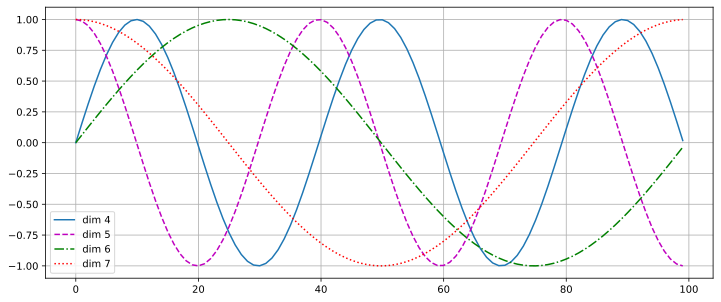

In [22]:
pe = PositionalEncoding(20, 0)
pe.initialize()
Y = pe(np.zeros((1, 100, 20)))
d2l.plot(np.arange(100), Y[0, :, 4:8].T, figsize=(12, 5),
         legend=["dim %d" % p for p in [4, 5, 6, 7]])

### 10.3.5 Encoder
Armed with all the essential components of `Transformer`, let us first build a `Transformer encoder` block. This `encoder` contains a `multi-head attention layer`, a `position-wise feed-forward network`, and two "add and norm" connection blocks. As shown in the code, for both of the attention model and the positional FFN model in the `EncoderBlock`, their outputs' dimension are equal to the `num_hiddens`. This is due to the nature of the residual block, as we need to add these outputs back to the original value during "add and norm".

In [23]:
class EncoderBlock(nn.Block):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(dropout)

    def forward(self, X, valid_len):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_len))
        return self.addnorm2(Y, self.ffn(Y))

Due to the residual connections, this block will not change the input shape. It means that the `num_hiddens` argument should be equal to the input size of the last dimension. In our toy example below, $\textrm{num_hiddens} = 24, \textrm{ffn_num_hiddens} = 48, \textrm{num_heads} = 8, \textrm{dropout} = 0.5$.

In [24]:
X = np.ones((2, 100, 24))
encoder_blk = EncoderBlock(24, 48, 8, 0.5)
encoder_blk.initialize()
encoder_blk(X, valid_len).shape

(2, 100, 24)

Now it comes to the implementation of the entire `Transformer encoder`. With the `Transformer encoder`, $n$ blocks of `EncoderBlock` stack up one after another. Because of the residual connection, the embedding layer size $d$ is same as the `Transformer` block output size. Also note that we multiply the embedding output by $\sqrt{d}$ to prevent its values from being too small.

In [25]:
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for _ in range(num_layers):
            self.blks.add(EncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_len, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_len)
        return X

Let us create an encoder with two stacked `Transformer encoder` blocks, whose hyperparameters are the same as before. Similar to the previous toy example's parameters, we add two more parameters $\textrm{vocab_size} = 200, \textrm{num_layers} = $2$ here.

In [26]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
encoder.initialize()
encoder(np.ones((2, 100)), valid_len).shape

(2, 100, 24)

### 10.3.6 Decoder
The `Transformer decoder` block looks similar to the `Transformer encoder` block. However, besides the two sub-layers (the multi-head attention layer and the positional encoding network), the `Transformer decoder` block contains a third sub-layer, which applies multi-head attention on the output of the encoder stack. Similar to the `Transformer encoder` block, the `Transformer decoder` block employs "add and norm", i.e., the residual connections and the layer normalization to connect each of the sub-layers.

To be specific, at timestep $t$, assume that $\mathbf x_t$ is the current input, i.e., the query. As illustrated in `Fig. 10.3.5`, the keys and values of the self-attention layer consist of the current query with all the past queries $\mathbf x_1, \ldots, \mathbf x_{t-1}$.

<img src="images/10_09.png" style="width:400px;"/>

During training, the output for the $t$-query could observe all the previous key-value pairs. It results in an different behavior from prediction. Thus, during prediction we can eliminate the unnecessary information by specifying the valid length to be $t$ for the $t^\textrm{th}$ query.

In [27]:
class DecoderBlock(nn.Block):
    # `i` means it is the i-th block in the decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_len = state[0], state[1]
        # `state[2][i]` contains the past queries for this block
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = np.concatenate((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if autograd.is_training():
            batch_size, seq_len, _ = X.shape
            # Shape: (batch_size, seq_len), the values in the j-th column are j+1
            valid_len = np.tile(np.arange(1, seq_len+1, ctx=X.ctx),
                                   (batch_size, 1))
        else:
            valid_len = None

        X2 = self.attention1(X, key_values, key_values, valid_len)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_len)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

Similar to the `Transformer encoder` block, $\textrm{num_hiddens}$ should be equal to the last dimension size of $X$.

In [28]:
decoder_blk = DecoderBlock(24, 48, 8, 0.5, 0)
decoder_blk.initialize()
X = np.ones((2, 100, 24))
state = [encoder_blk(X, valid_len), valid_len, [None]]
decoder_blk(X, state)[0].shape

(2, 100, 24)

The construction of the entire `Transformer decoder` is identical to the `Transformer encoder`, except for the additional dense layer to obtain the output confidence scores.

Let us implement the `Transformer decoder` `TransformerDecoder`. Besides the regular hyperparameters such as the `vocab_size` and `num_hiddens`, the `Transformer decoder` also needs the `Transformer encoder`'s outputs `enc_outputs` and `env_valid_len`.

In [29]:
class TransformerDecoder(d2l.Decoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(DecoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.Dense(vocab_size, flatten=False)

    def init_state(self, enc_outputs, env_valid_len, *args):
        return [enc_outputs, env_valid_len, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state

### 10.7.3 Training
Finally, we can build an `encoder-decoder` model with the `Transformer` architecture. Similar to the `seq2seq` with attention model in `Section 10.2`, we use the following hyperparameters: two Transformer blocks with both the embedding size and the block output size to be $32$. In addition, we use $4$ heads, and set the hidden size to be twice larger than the output size.

loss 0.033, 4212 tokens/sec on gpu(0) 


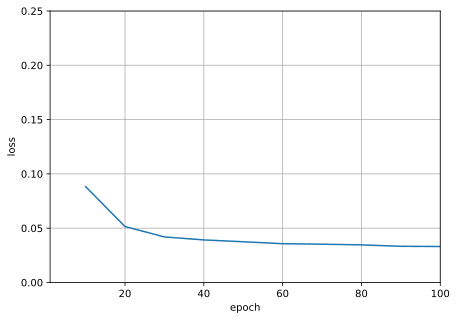

In [30]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 10
lr, num_epochs, ctx = 0.005, 100, d2l.try_gpu()
ffn_num_hiddens, num_heads = 64, 4

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
d2l.train_s2s_ch9(model, train_iter, lr, num_epochs, ctx)

As we can see from the training time and accuracy, compared with the `seq2seq` model with attention model, `Transformer` runs faster per epoch, and converges faster at the beginning.

We can use the trained `Transformer` to translate some simple sentences.

In [31]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !']:
    print(sentence + ' => ' + d2l.predict_s2s_ch9(model, sentence, src_vocab, tgt_vocab, num_steps, ctx))

Go . => <unk> !
Wow ! => <unk> !
I'm OK . => je vais bien .
I won ! => je l'ai emporté !


##### Summary
+ The Transformer model is based on the encoder-decoder architecture.
+ Multi-head attention layer contains $h$ parallel attention layers.
+ Position-wise feed-forward network consists of two dense layers that apply to the last dimension.
+ Layer normalization differs from batch normalization by normalizing along the last dimension (the feature dimension) instead of the first (batch size) dimension.
+ Positional encoding is the only place that adds positional information to the Transformer model.

##### Exercises
1. Try a larger size of epochs and compare the loss between seq2seq model and Transformer model.
2. Can you think of any other benefit of positional encoding?
3. Compare layer normalization and batch normalization, when shall we apply which?